In [1]:
# This script demonstrates the capabilities of cluster_slug by using
# it to re-analyze the M31 star clusters catalog of Johnson et al. (2015, ApJ)

# Import the libraries we'll need
from astropy.io import ascii
from astropy.io import fits
import emcee
from astropy import table
from astropy.table import unique, Table, hstack, Column
import sys
from numpy import inf
import numpy as np
import numpy.ma as ma
import time
from matplotlib.pyplot import figure as fig
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from slugpy.cluster_slug import cluster_slug
from slugpy import * 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

In [2]:
#Imported AP fits files which include best fit of mass and age data already 

apdata = Table.read('apdata-cluster_6phot+agemass.fits')
print("Reading AP Cluster Data (Phot+Agemasss)...")
apdata_12clusters = Table.read('apdata-cluster_6phot+agemass_select.fits')
print("Reading AP 12 Cluster Data (Phot+AgeMass)...")

apdata_good_phot6filts=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Photometery_Tables/apdata_goodphot_6filts.fits')


LEGUS_PHAT_PadKroupa_prop=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_prop.fits')
LEGUS_PHAT_PadKroupa_phot=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_phot.fits')

dmod_M31=24.47 

Reading AP Cluster Data (Phot+Agemasss)...
Reading AP 12 Cluster Data (Phot+AgeMass)...


In [3]:
#Extract photometry from the AP PHAT catalog and pack it into arrays
cluster_id = np.array(apdata_good_phot6filts['ID'])

#F275W filter with error
#apdata_good_phot6filts['MAG275'][apdata_good_phot6filts['MAG275'] == 'INDEF'] = -99
#m275 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG275'], dtype='float64'), -99) - dmod_M31
#apdata_good_phot6filts['SIG275'][apdata_good_phot6filts['SIG275'] == 'INDEF'] = -99
#m275err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG275'], 
#                                   dtype='float64'), -99)

#F336W filter with error
apdata_good_phot6filts['MAG336'][apdata_good_phot6filts['MAG336'] == 'INDEF'] = -99
m336 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG336'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG336'][apdata_good_phot6filts['SIG336'] == 'INDEF'] = -99
m336err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG336'], 
                                   dtype='float64'), -99)

#F475W filter with error
apdata_good_phot6filts['MAG475'][apdata_good_phot6filts['MAG475'] == 'INDEF'] = -99
m475 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG475'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG475'][apdata_good_phot6filts['SIG475'] == 'INDEF'] = -99
m475err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG475'],
                                   dtype='float64'), -99)
#F814W filter with error
apdata_good_phot6filts['MAG814'][apdata_good_phot6filts['MAG814'] == 'INDEF'] = -99
m814 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG814'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG814'][apdata_good_phot6filts['SIG814'] == 'INDEF'] = -99
m814err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG814'],
                                   dtype='float64'), -99)

#F110W filter with error
apdata_good_phot6filts['MAG110'][apdata_good_phot6filts['MAG110'] == 'INDEF'] = -99
m110 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG110'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG110'][apdata_good_phot6filts['SIG110'] == 'INDEF'] = -99
m110err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG110'],
                                   dtype='float64'), -99)

#F160W filter with error 
apdata_good_phot6filts['MAG160'][apdata_good_phot6filts['MAG160'] == 'INDEF'] = -99
m160 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG160'],dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG160'][apdata_good_phot6filts['SIG160'] == 'INDEF'] = -99
m160err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG160'],
                                   dtype='float64'), -99)

apdata_good_phot6filts_logm=apdata_good_phot6filts['BEST_MASS']
apdata_good_phot6filts_logt=apdata_good_phot6filts['BEST_AGE']
apdata_good_phot6filts_logx=apdata_good_phot6filts['CMD_AV_BEST']

/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)


In [4]:
# Mask entries with bad data in one or more filters for the actual M31 data
valid = np.logical_and(np.logical_not(m336.mask),
                       np.logical_not(m475.mask))
valid = np.logical_and(valid, np.logical_not(m814.mask))
valid = np.logical_and(valid, np.logical_not(m110.mask))
valid = np.logical_and(valid, np.logical_not(m160.mask))
#valid = np.logical_and(valid, np.logical_not(m160.mask))

In [5]:
# Create array of photometry to pass to cluster_slug
phot=np.zeros((np.sum(616), 5)) #Creating an empty array of zeros with the shape of 616x5 
photerr=np.zeros((np.sum(616),5))#Creating an empty array of zeros with the shape of 616x5 


In [6]:
#Defining the filters defined in the parameter file. Filters used for M3!
#phot[:,0] = m275[valid]
phot[:,0] = m336[valid]
phot[:,1] = m475[valid]
phot[:,2] = m814[valid]
phot[:,3] = m110[valid]
phot[:,4] = m160[valid] 
#photerr[:,0] = m275err[valid]
photerr[:,0] = m336err[valid]
photerr[:,1] = m475err[valid]
photerr[:,2] = m814err[valid]
photerr[:,3] = m110err[valid]
photerr[:,4] = m160err[valid] 

# Set up filter list (Commented out the original list of filters originally for chdata) for M31 AP PHAT 
filters = ['WFC3_UVIS_F336W', 'ACS_F475W', 'ACS_F814W', 
           'WFC3_IR_F110W', 'WFC3_IR_F160W']

In [7]:
# Define the sample density (For AP PHAT Data)
def sample_density(physprop):
    logm = physprop[:,0]
    logt = physprop[:,1]
    #logx = physprop[:,2]
    sden = np.ones(len(logm))
    sden[logm > 4] = sden[logm > 4] * 1.0/10.**(logm[logm > 4]-4)
    sden[logt > 8] = sden[logt > 8] * 1.0/10.**(logt[logt > 8]-8)
    #sden[logx > 12]= sden[logx >12] * 1.0/10.**(logx[logx >12]-12)
    return sden

In [8]:
# Set up the cluster_slug object; this command will take care of
# reading the library and converting the data to the Vega photometric
# system
print("Reading cluster_slug library...")
cs=cluster_slug(photsystem='Vega', filters=filters, bw_phot=0.25,
                ktype='gaussian',sample_density=sample_density,
                libname='LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials')
# Set priors to be flat in log T and A_V, but vary with logm as
# p(log M) ~ 1/M
def priorfunc(physprop):
    # Note: physprop is an array of shape (N, 3) where physprop[:,0] =
    # log M, physprop[:,1] = log T, physprop[:,2] = A_V
    return 1.0/np.exp(physprop[:,0])
cs.priors = priorfunc

Reading cluster_slug library...


Computing posterior PDFs...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Computation time: 459.546902 seconds total, 0.373009 seconds / PDF


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


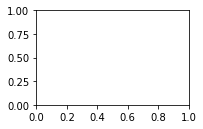

In [9]:
# Start timing
print("Computing posterior PDFs...")
lasttime = time.clock()


# Compute marginal PDFs of mass and age
logm, mpdf = cs.mpdf(0, phot, photerr, filters=filters)
logt, tpdf = cs.mpdf(1, phot, photerr, filters=filters)
logx, xpdf = cs.mpdf(2, phot, photerr, ngrid=1000, filters=filters)

# End timing
newtime = time.clock()
tottime = newtime - lasttime

# Print timing results
print("Computation time: {:f} seconds total, {:f} seconds / PDF".
      format(tottime, tottime/phot.shape[0]/2))

# Set up a plot window
plt.figure(1, figsize=(6,8))
plt.subplot(4,2,1)

In [10]:
# Compute the mean of the posterior PDFs returned by cluster_slug
mmean = np.sum(logm*mpdf*(logm[1]-logm[0]), axis=1)
tmean = np.sum(logt*tpdf*(logt[1]-logt[0]), axis=1)
xmean = np.sum(logx*xpdf*(logx[1]-logt[0]), axis=1)

# Compute the 25th, 50th, and 75th percentiles of the posterior PDFs
mpdfsum = np.cumsum(mpdf, axis=1)*(logm[1]-logm[0])
mpercentiles = np.array([
    logm[np.argmax(np.greater(mpdfsum, 0.1), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.5), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.9), axis=1)]])
tpdfsum = np.cumsum(tpdf, axis=1)*(logt[1]-logt[0])
tpercentiles = np.array([
    logt[np.argmax(np.greater(tpdfsum, 0.1), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.5), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.9), axis=1)]])
xpdfsum = np.cumsum(xpdf, axis=1)*(logx[1]-logx[0])
xpercentiles = np.array([
    logx[np.argmax(np.greater(xpdfsum, 0.1), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.5), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.9), axis=1)]])

In [11]:
# For each model, find the best match in the library for the 12 hand-picked clusters
matches, dist = cs.bestmatch(phot, filters=filters, nmatch=1)
dist = dist/np.sqrt(len(filters))

In [12]:
mp25=mpercentiles[0]
mp50=mpercentiles[1]
mp75=mpercentiles[2]
tp25=tpercentiles[0]
tp50=tpercentiles[1]
tp75=tpercentiles[2]
xp25=xpercentiles[0]
xp50=xpercentiles[1]
xp75=xpercentiles[2]

In [13]:
#Difference of the median of the Mass PDF & the previous mass apdata estimates in apdata

diffPDFmed_M_apdata=apdata_good_phot6filts_logm-mpercentiles[1]
diffPDFmed_A_apdata=apdata_good_phot6filts_logt-tpercentiles[1]
diffPDFmed_X_apdata=apdata_good_phot6filts_logx-xpercentiles[1]


In [14]:
apdata_good_phot6filts_BT=apdata_good_phot6filts['BEST_METHOD']
indBT=np.where(apdata_good_phot6filts_BT!='M')
indBTM=np.where(apdata_good_phot6filts_BT=='M')
apdata_good_phot6filts.remove_rows(indBT)

In [15]:
#Difference of the median of the Mass PDF & the previous mass apdata estimates for only CMD estimates in apdata
diff_PDFMedian_m_apdata=apdata_good_phot6filts_logm[indBTM[0]]-mpercentiles[1][indBTM[0]]


In [16]:
#PERCENTILES FOR MASS differences for clusters with CMD best method
sorted_mPDF_apdataMedian=np.sort(diff_PDFMedian_m_apdata)
diff_PDFMedian_m_apdata_25q=np.median(sorted_mPDF_apdataMedian[0:179])
diff_PDFMedian_m_apdata_75q=np.median(sorted_mPDF_apdataMedian[180:358])

In [17]:
#P25, Median, and P75 of CMD Log Mass and SLUG Mass Median
diff_PDFMedian_m_apdata_25q,np.median(diff_PDFMedian_m_apdata),diff_PDFMedian_m_apdata_75q

(-0.17694480280514657, 0.07297883644236847, 0.28248157480502845)

In [18]:
#IQR for Mass PDF Median - apdata (75th - 25th quartile values)
MassIQR=diff_PDFMedian_m_apdata_75q-diff_PDFMedian_m_apdata_25q
MassIQR

0.459426377610175

In [19]:
#Sigma of Mass PDF Median - CMD Log Mass
np.std(diff_PDFMedian_m_apdata)

0.43531008972952856

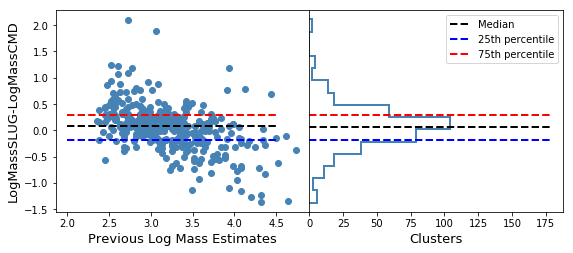

In [58]:
#Slug Masses vs CMD Masses with ONLY CMD BEST METHOD used 
x=np.arange(2,5,0.5)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(mpercentiles[1][indBTM[0]],diff_PDFMedian_m_apdata, color='steelblue')
plt.plot(x,np.median(diff_PDFMedian_m_apdata)*np.ones(6),'k--',lw=2)
plt.plot(x,diff_PDFMedian_m_apdata_25q*np.ones(6),'b--',lw=2)
plt.plot(x,diff_PDFMedian_m_apdata_75q*np.ones(6),'r--',lw=2)
plt.ylabel('LogMassSLUG-LogMassCMD', fontsize=13)
plt.xlabel('Previous Log Mass Estimates', fontsize=13);


plt.subplot(1,2,2)
a=np.arange(0,180,1)
plt.hist(diff_PDFMedian_m_apdata, orientation='horizontal',histtype='step',lw=2,bins=15,color='steelblue')
plt.plot(a,np.median(diff_PDFMedian_m_apdata)*np.ones(180),'k--',lw=2,label='Median')
plt.plot(a,diff_PDFMedian_m_apdata_25q*np.ones(180),'b--',lw=2,label='25th percentile')
plt.plot(a,diff_PDFMedian_m_apdata_75q*np.ones(180),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMDMassEst_vs_CMDMassEst_5filts.pdf')

In [26]:
#Difference of the median of the Age PDF & the previous Age apdata estimates for only CMD estimates in apdata
diff_PDFMedian_t_apdata=apdata_good_phot6filts_logt[indBTM[0]]-tpercentiles[1][indBTM[0]]

In [27]:
#PERCENTILES FOR AGE differences for clusters with CMD best method
sorted_tPDF_apdataMedian=np.sort(diff_PDFMedian_t_apdata)
diff_PDFMedian_t_apdata_25q=np.median(sorted_tPDF_apdataMedian[0:179])
diff_PDFMedian_t_apdata_75q=np.median(sorted_tPDF_apdataMedian[180:358])

In [28]:
#P25, Median, and P75 of CMD Log Age and SLUG Age Median
diff_PDFMedian_t_apdata_25q,np.median(diff_PDFMedian_t_apdata),diff_PDFMedian_t_apdata_75q


(-0.35905489980382477, 9.359791874885559e-08, 0.3220468187690013)

In [29]:
#IQR for Age PDF Median - apdata
AgeIQR=diff_PDFMedian_t_apdata_75q-diff_PDFMedian_t_apdata_25q
AgeIQR

0.6811017185728261

In [30]:
#standard deviation (sigma) of Age median of the PDF - Age apdata
np.std(diff_PDFMedian_t_apdata)

0.6215743689425293

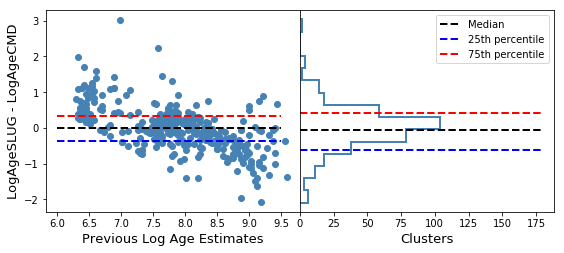

In [59]:
#Slug Ages vs CMD Ages with ONLY CMD BEST METHOD used 
Y=np.arange(6,10,0.5)
plt.subplot(1,2,1)
plt.scatter(tpercentiles[1][indBTM[0]],diff_PDFMedian_t_apdata, color='steelblue')
plt.plot(Y,np.median(diff_PDFMedian_t_apdata)*np.ones(8),'k--',lw=2)
plt.plot(Y,diff_PDFMedian_t_apdata_25q*np.ones(8),'b--',lw=2)
plt.plot(Y,diff_PDFMedian_t_apdata_75q*np.ones(8),'r--',lw=2)
plt.ylabel('LogAgeSLUG - LogAgeCMD', fontsize=13)
plt.xlabel('Previous Log Age Estimates', fontsize=13);

plt.subplot(1,2,2)
b=np.arange(0,180,1)
plt.hist(diff_PDFMedian_m_apdata, orientation='horizontal',histtype='step',lw=2,bins=15,color='steelblue')
plt.plot(b,np.median(diff_PDFMedian_t_apdata)*np.ones(180),'k--',lw=2,label='Median')
plt.plot(b,diff_PDFMedian_t_apdata_25q*np.ones(180),'b--',lw=2,label='25th percentile')
plt.plot(b,diff_PDFMedian_t_apdata_75q*np.ones(180),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()
plt.xlabel('Clusters', fontsize=13);

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMDAgeEst_vs_CMDAgeEst_5filts.pdf')


In [32]:
#Difference of the median of the Av PDF & the previous Av apdata estimates for only CMD estimates in apdata
diff_PDFMedian_x_apdata=apdata_good_phot6filts_logx[indBTM[0]]-xpercentiles[1][indBTM[0]]

In [33]:
#PERCENTILES FOR EXTINCTION differences for clusters with CMD best method
sorted_xPDF_apdataMedian=np.sort(diff_PDFMedian_x_apdata)
diff_PDFMedian_x_apdata_25q=np.median(sorted_xPDF_apdataMedian[0:179])
diff_PDFMedian_x_apdata_75q=np.median(sorted_xPDF_apdataMedian[180:358])


In [34]:
#P25, Median, and P75 of CMD Log Extinction and SLUG Extinction Median
diff_PDFMedian_x_apdata_25q, np.median(diff_PDFMedian_x_apdata),diff_PDFMedian_x_apdata_75q


(-0.35238500136744055, -0.00870898903950601, 0.44157848932930627)

In [35]:
#IQR for Extinction PDF Median - apdata
AvIQR=diff_PDFMedian_x_apdata_75q-diff_PDFMedian_x_apdata_25q
AvIQR

0.7939634906967468

In [36]:
#standard deviation (sigma) of Extinction median of the PDF - Extinction apdata
np.std(diff_PDFMedian_x_apdata)

2.3389595133296637

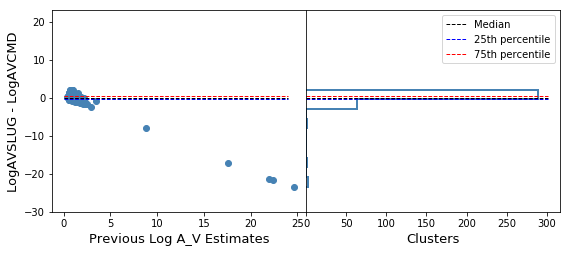

In [37]:
#plotting the median of the PDF versus the difference of the apdata Av minus the median of the PDF for all 
#apdata clusters with ONLY best method CMD

z=np.arange(0,25,1)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(xpercentiles[1][indBTM[0]],diff_PDFMedian_x_apdata, color='steelblue')
plt.plot(z,np.median(diff_PDFMedian_x_apdata)*np.ones(25),'k--',lw=1)
plt.plot(z,diff_PDFMedian_x_apdata_25q*np.ones(25),'b--',lw=1)
plt.plot(z,diff_PDFMedian_x_apdata_75q*np.ones(25),'r--',lw=1)
plt.ylim(-30,23)
#plt.xlim(0,5)
plt.ylabel('LogAVSLUG - LogAVCMD', fontsize=13)
plt.xlabel('Previous Log A_V Estimates', fontsize=13);


plt.subplot(1,2,2)
c=np.arange(0,302,1)
plt.hist(diff_PDFMedian_x_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(c,np.median(diff_PDFMedian_x_apdata)*np.ones(302),'k--',lw=1,label='Median')
plt.plot(c,diff_PDFMedian_x_apdata_25q*np.ones(302),'b--',lw=1,label='25th percentile')
plt.plot(c,diff_PDFMedian_x_apdata_75q*np.ones(302),'r--',lw=1,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.ylim(-30,23)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
#plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/Model_Comparison_Files/DiffofMassModels_vs_PreviousMassEst.pdf')

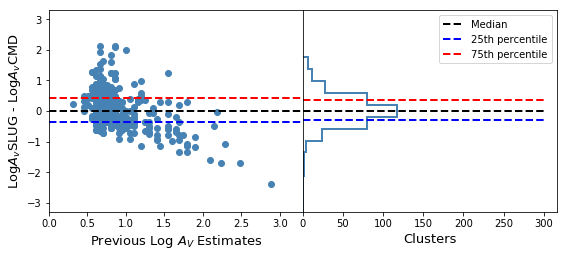

In [53]:
#Zoomed in version of the plot above between y values of -5 to 5

z=np.arange(0,6,1)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(xpercentiles[1][indBTM[0]],diff_PDFMedian_x_apdata,color='steelblue')
plt.plot(z,np.median(diff_PDFMedian_x_apdata)*np.ones(6),'k--',lw=2)
plt.plot(z,diff_PDFMedian_x_apdata_25q*np.ones(6),'b--',lw=2)
plt.plot(z,diff_PDFMedian_x_apdata_75q*np.ones(6),'r--',lw=2)
plt.ylim(-3.3,3.3)
plt.xlim(0,3.3)
plt.ylabel('Log$A_v$SLUG - Log$A_v$CMD', fontsize=13)
plt.xlabel('Previous Log $A_V$ Estimates', fontsize=13);


plt.subplot(1,2,2)
c=np.arange(0,302,1)
plt.hist(diff_PDFMedian_x_apdata, orientation='horizontal',histtype='step',lw=2,bins=54, color='steelblue')
plt.plot(c,np.median(diff_PDFMedian_x_apdata)*np.ones(302),'k--',lw=2,label='Median')
plt.plot(c,diff_PDFMedian_x_apdata_25q*np.ones(302),'b--',lw=2,label='25th percentile')
plt.plot(c,diff_PDFMedian_x_apdata_75q*np.ones(302),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.ylim(-4,4)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMDA_vEst_vs_CMDA_vEst_5filts.pdf')